In [1]:
import heartpy as hp
from heartpy.datautils import rolling_mean
from heartpy.peakdetection import detect_peaks
import torch
import torch.nn as nn
import torch.nn.functional as F 
from resnet1d import Res34SimSiam, Res34SimSiamSplitHeads
from dataset import Dataset_per_file, Dataset_whole, Dataset_ori, Dataset_valsubset
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
from torch.autograd import Variable
import os
import numpy as np
from tqdm import tqdm
import argparse
import random
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import sys
import os
import matplotlib.pyplot as plt
import gc

from collections import OrderedDict

import pacmap
from annoy import AnnoyIndex
import neurokit2 as nk
import pickle as pkl


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
val_subset_dataset = Dataset_valsubset('/labs/hulab/stark_stuff/ppg_ecg_project/data/UCSF_valsubset_ECGs.npy', '/labs/hulab/stark_stuff/ppg_ecg_project/data/UCSF_valsubset_PPGs.npy', '/labs/hulab/stark_stuff/ppg_ecg_project/data/UCSF_valsubset_labels.npy')
print(len(val_subset_dataset))

27858


In [3]:
val_loader = DataLoader(val_subset_dataset, batch_size=2500, shuffle=False, num_workers=0)

In [13]:
# for batch_idx, (ECG, PPG, target) in enumerate(tqdm(val_loader)):
#     ECG_npy = ECG.squeeze().cpu().numpy()    
#     PPG_npy = PPG.squeeze().cpu().numpy()
    
#     print(ECG_npy.shape, PPG_npy.shape)
    
#     rol_mean = rolling_mean(PPG_npy, windowsize = 0.75, sample_rate = 80.0)
#     PPG_wd = detect_peaks(PPG_npy, rol_mean, ma_perc = 20, sample_rate = 80.0)
    
# #     PPG_dummy = np.zeros_like(PPG_npy)
# #     PPG_dummy[PPG_wd['peaklist']] = PPG_wd['ybeat']
    
# #     plt.figure(figsize=(5, 1))
# #     plt.plot(PPG_npy, c='k')
# #     plt.scatter(PPG_wd['peaklist'], PPG_wd['ybeat'], c='r')
# #     plt.show()
    
# #     ECG_wd, m = hp.process(ECG_npy, sample_rate = 80.0)
#     ECG_dummy = np.zeros_like(ECG_npy)
# #     ECG_dummy[ECG_wd['peaklist']] = ECG_wd['ybeat']

#     _, rpeaks  = nk.ecg_peaks(ECG_npy, sampling_rate=80)
#     _, waves_peak = nk.ecg_delineate(ECG_npy, rpeaks, sampling_rate=80, method="peak")
    
    
# #     plt.figure(figsize=(5, 1))
# #     plt.plot(ECG_npy, c='k')
# # #     plt.scatter(ECG_wd['peaklist'], ECG_wd['ybeat'], c='r')
# #     ECG_dummy[rpeaks['ECG_R_Peaks']] = ECG_npy[rpeaks['ECG_R_Peaks']]
# #     plt.scatter(rpeaks['ECG_R_Peaks'], ECG_npy[rpeaks['ECG_R_Peaks']], c='r')
# #     plt.show()
    
# #     plt.figure(figsize=(5, 1))
# #     plt.plot(ECG_dummy, c='k')
# #     plt.show()

# #     plt.figure(figsize=(5, 1))
# #     plt.plot(PPG_dummy, c='k')
# #     plt.show()

# #     break
    

#     plt.figure(figsize=(10, 2))
#     plt.plot(ECG_npy)
#     plt.scatter(waves_peak['ECG_P_Peaks'], ECG_npy[waves_peak['ECG_P_Peaks']], c='r')
#     plt.show()
# #     print(rpeaks)
# #     plt.figure(figsize=(10, 2))
# #     plt.plot(ECG_npy)
# #     plt.scatter(rpeaks['ECG_R_Peaks'], ECG_npy[rpeaks['ECG_R_Peaks']], c='r')
    
# #     print(rpeaks)
    
    
# #     rol_mean = rolling_mean(ECG_npy, windowsize = 0.75, sample_rate = 80.0)
# #     ECG_wd = detect_peaks(ECG_npy, rol_mean, ma_perc = 20, sample_rate = 80.0)
    
# #     ECG_dummy = np.zeros_like(ECG_npy)
# #     ECG_dummy[ECG_wd['peaklist']] = ECG_wd['ybeat']
    
# #     plt.figure(figsize=(5, 1))
# #     plt.plot(ECG_npy)
# #     plt.show()
# #     plt.figure(figsize=(5, 1))
# #     plt.plot(ECG_npy)
# #     plt.scatter(ECG_wd['peaklist'], ECG_wd['ybeat'], c='r')
# #     plt.figure(figsize=(5, 1))
# #     plt.plot(ECG_dummy)

#     print('------------------------------------------------------------------------')
    
# #     break

In [17]:
all_rpeaks = pkl.load(open(f'/labs/hulab/stark_stuff/ppg_ecg_project/data/UCSF_val_selectedECG_PQRST/{batch_idx}_rpeaks.pkl', 'rb'))
all_waves_peaks = pkl.load(open(f'/labs/hulab/stark_stuff/ppg_ecg_project/data/UCSF_val_selectedECG_PQRST/{batch_idx}_waves_peak.pkl', 'rb'))    


In [49]:
len(val_loader)

12

  0%|          | 0/2500 [00:00<?, ?it/s]

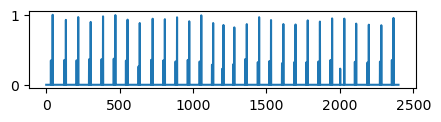

[  32  124  207  292  377  460  543  629  715  798  881  964 1045 1129
 1199 1273 1355 1441 1520 1606 1690 1772 1854 1936 2002 2102 2188 2273
 2354]


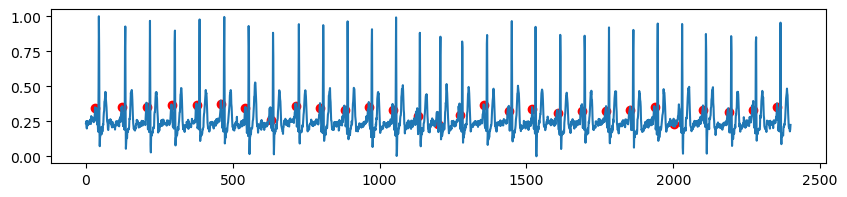


  0%|          | 1/2500 [00:00<13:59,  2.98it/s]

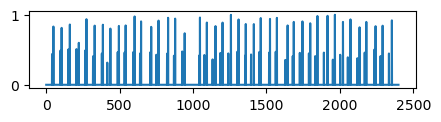

[  40   97  151  206  266  319  379  416  487  534  593  639  709  750
  823  870  926 1042 1077 1133 1186 1240 1302 1355 1395 1452 1518 1563
 1628 1679 1727 1789 1832 1891 1952 2002 2054 2119 2169 2235 2277 2334]


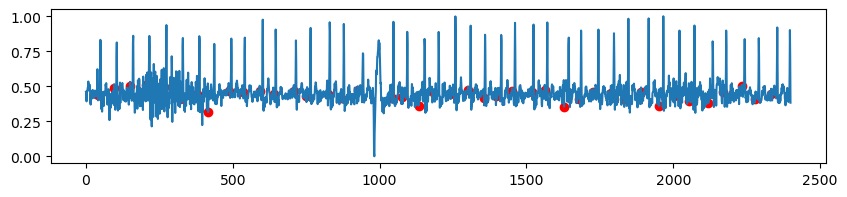


  0%|          | 2/2500 [00:00<14:11,  2.93it/s]

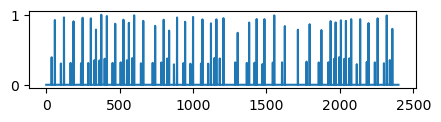

[  37  100  166  237  286  329  363  398  452  507  550  586  645  725
  784  824  870  934  982 1054 1103 1146 1182 1287 1366 1419 1473 1543
 1606 1773 1856 1922 1962 1995 2030 2064 2115 2183 2238 2300 2340]


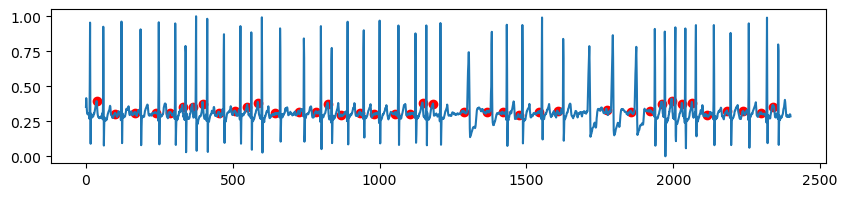


  0%|          | 3/2500 [00:01<14:09,  2.94it/s]

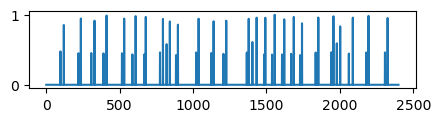

[  97  220  307  390  516  587  668  775  820  884 1021 1124 1207 1366
 1404 1484 1538 1606 1668 1729 1835 1942 1979 2061 2179 2307]


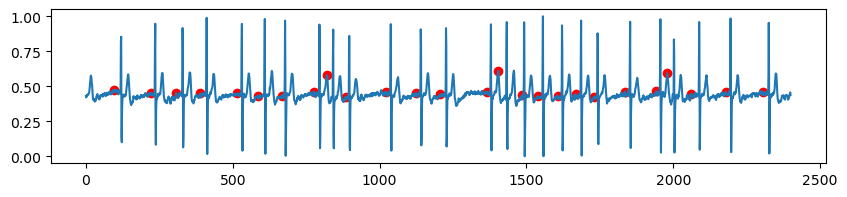


  0%|          | 4/2500 [00:01<14:07,  2.94it/s]

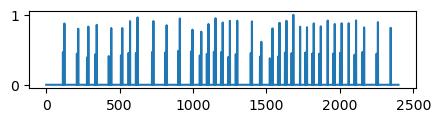

[ 114  209  278  334  426  509  561  611  721  810  900  986 1046 1094
 1142 1191 1241 1291 1393 1456 1523 1579 1626 1671 1765 1812 1859 1954
 2001 2100 2154 2250]


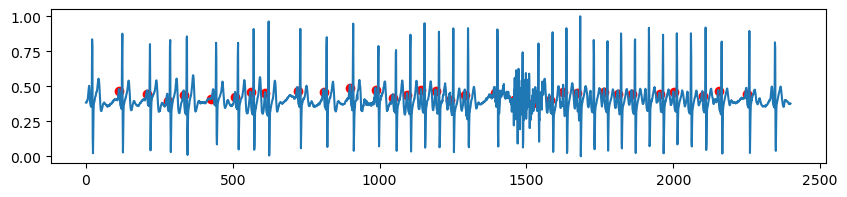


  0%|          | 5/2500 [00:01<14:07,  2.94it/s]

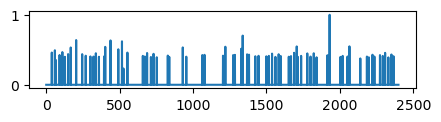

[  38   66  110  149  245  301  338  394  491  526  658  687  731  828
  930 1063 1204 1273 1328 1368 1424 1499 1538 1583 1652 1688 1713 1778
 1822 1915 2004 2052 2184 2222 2273 2308 2351]


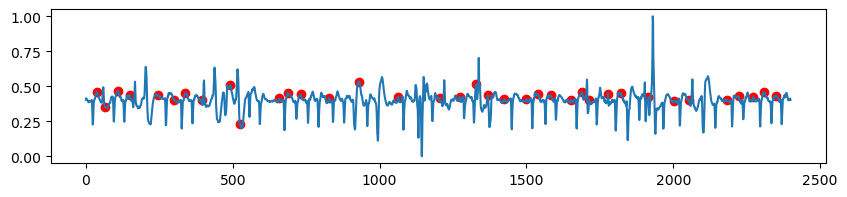


  0%|          | 6/2500 [00:02<14:00,  2.97it/s]

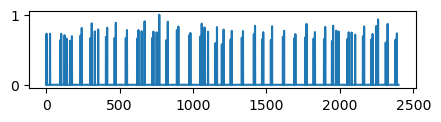

[   2   95  125  162  234  302  331  407  466  542  620  650  722  752
  819  890  974 1050 1078 1152 1196 1256 1332 1414 1470 1530 1612 1689
 1765 1821 1892 1946 1975 2052 2080 2157 2214 2247 2312 2379]


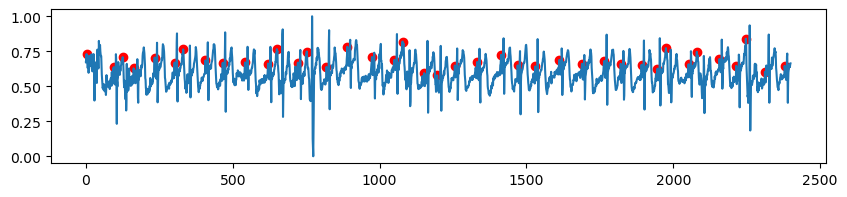


  0%|          | 7/2500 [00:02<14:02,  2.96it/s]

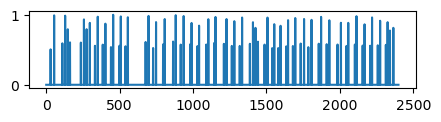

[  30  110  147  236  275  332  385  441  499  540  677  728  796  864
  916  982 1030 1090 1144 1210 1264 1318 1387 1425 1487 1539 1580 1635
 1680 1733 1785 1856 1910 1984 2045 2102 2155 2206 2258 2313 2341]


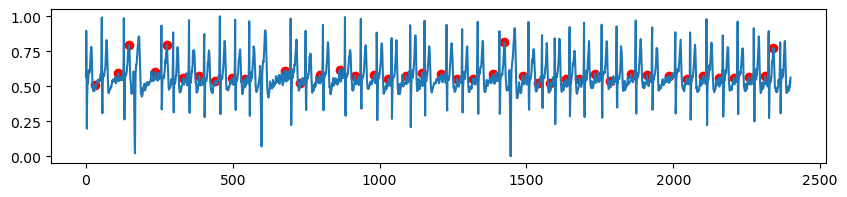


  0%|          | 8/2500 [00:02<14:07,  2.94it/s]

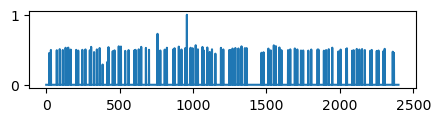

[  21   72  113  150  204  246  297  326  364  417  453  494  538  601
  630  679  758  807  866  903  947  983 1018 1064 1097 1129 1190 1247
 1269 1309 1353 1466 1513 1550 1588 1647 1693 1735 1785 1848 1891 1924
 1990 2043 2084 2115 2151 2207 2251 2297 2360]


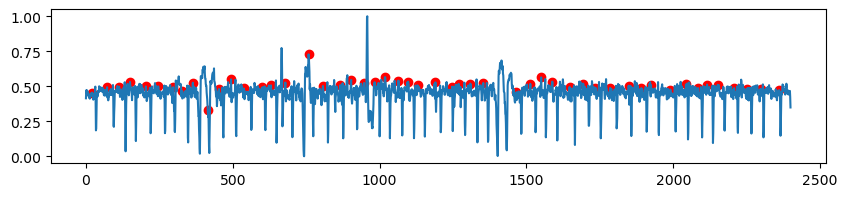


  0%|          | 9/2500 [00:03<14:04,  2.95it/s]

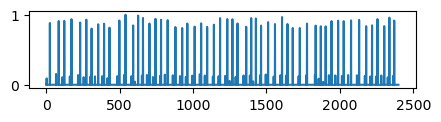

[   3   67  110  161  217  255  300  332  381  417  484  530  580  604
  652  686  727  777  808  862  911  951  995 1046 1080 1135 1174 1219
 1249 1290 1344 1387 1409 1456 1495 1549 1595 1633 1719 1771 1830 1855
 1886 1925 1969 2014 2056 2116 2170 2206 2246 2282 2326 2364]


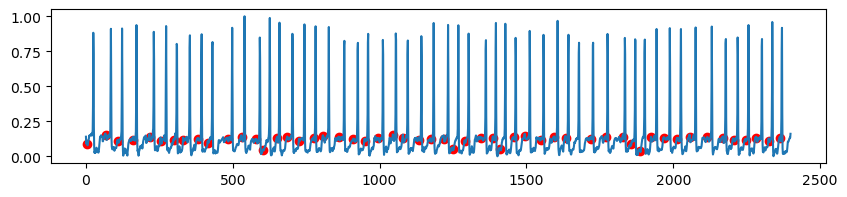


  0%|          | 10/2500 [00:03<14:06,  2.94it/s]

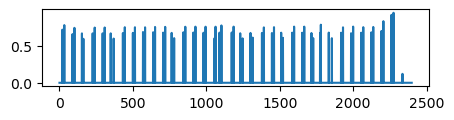

[  20   89  153  226  294  349  432  500  569  638  706  764  844  912
  981 1056 1090 1173 1231 1301 1379 1447 1510 1585 1653 1716 1775 1834
 1918 1986 2055 2124 2193 2261]


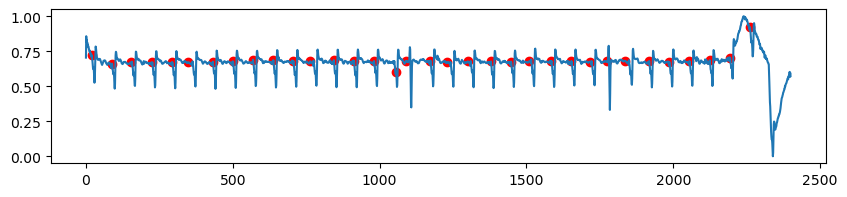


  0%|          | 0/12 [00:04<?, ?it/s]           


In [54]:
for batch_idx, (ECG, PPG, target) in enumerate(tqdm(val_loader, position=0, leave=True)):
        
    PPG = PPG.cuda().float()
    ECG = ECG.cuda().float()
    
    all_rpeaks = pkl.load(open(f'/labs/hulab/stark_stuff/ppg_ecg_project/data/UCSF_val_selectedECG_PQRST/{batch_idx}_rpeaks.pkl', 'rb'))
    all_waves_peaks = pkl.load(open(f'/labs/hulab/stark_stuff/ppg_ecg_project/data/UCSF_val_selectedECG_PQRST/{batch_idx}_waves_peak.pkl', 'rb'))    

    all_ecg_peaks = []
    tmp = ECG.cpu().numpy()
    counter = 0
    ecg_labels = []
    successful_idxs = []
    for idx, ecg in enumerate(tqdm(tmp, position=1, leave=False)):
        ECG_npy = ecg.squeeze()
        rpeaks = all_rpeaks[idx]
        wave_peaks = all_waves_peaks[idx]
        if rpeaks is None and wave_peaks is None:
            counter += 1
        else:
            ECG_peak = np.zeros_like(ECG_npy)
            ECG_peak[rpeaks['ECG_R_Peaks']] = ECG_npy[rpeaks['ECG_R_Peaks']]
            ppeak_idx = np.asarray(wave_peaks['ECG_P_Peaks'])
            ppeak_idx = ppeak_idx[~np.isnan(ppeak_idx)].astype(int)
            ECG_peak[ppeak_idx] = ECG_npy[ppeak_idx]
            all_ecg_peaks.append(ECG_peak.reshape((1, ECG_peak.shape[0])))
            successful_idxs.append(idx)
            plt.figure(figsize=(5, 1))
            plt.plot(ECG_peak)
            plt.show()
            
        plt.figure(figsize=(10, 2))
        plt.plot(ECG_npy)
        rpeak_idx = np.asarray(wave_peaks['ECG_P_Peaks'])
        rpeak_idx = rpeak_idx[~np.isnan(rpeak_idx)].astype(int)
        print(rpeak_idx)
        plt.scatter(rpeak_idx, ECG_npy[rpeak_idx], c='r')
        plt.show()
        
        if idx>=10: break
    
        
    break
